In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from scipy import ndimage 
tf.compat.v1.set_random_seed(1)

In [2]:
# ------------------------------------------- Utility Functions -------------------------------------------
""" Creates subsequences of the original sequence to fit LSTM structure
 
Args:
    sequence_1: the first sequence which gets converted into multiple subarrays of length: n_steps
    sequence_2: the second sequence, each n_steps'th element will be part of the output array
    n_steps: the amount of time steps used as an input into the LSTM for prediction

Returns:
    A tuple of 2 numpy arrays in the required format
    
    X.shape = (X.shape[0] - n_steps, n_steps)
    y.shape = (X.shape[0] - n_steps, 1)

"""
def subsequences(sequence_X, sequence_y, n_steps):
    if n_steps > len(sequence_X):
        raise Exception('subsequences: n_steps should not exceed the sequence length')
    
    X, y = list(), list()
    for i in range(len(sequence_X)):
        end_ix = i + n_steps

        if end_ix > len(sequence_X):
            break

        X.append(sequence_X[i:end_ix])
        y.append(sequence_y[end_ix-1])
        
    return np.array(X), np.array(y)


""" Subsample array to decrease the amount of data

Args:
    sequence: the input array to be subsampled
    d_sample: sample frequency, meaning every d_sample'th element will be part of the output
    
Returns:
    The subsampled array

"""
def subsample(sequence, d_sample):
    return sequence[::d_sample]


""" Smooth array to decrease measurement noise

Args: 
    sequence: the input array to be smoothed
    sigma: parameter for the gauss filtering

Returns:
    The smoothed array
"""
def smooth(sequence, sigma):
    return ndimage.filters.gaussian_filter(sequence, sigma)


""" Aligns two sequences

    In this context this means subsampling the first array so that it afterwards has the same size as the second array
    
Args: 
    sequence_1: arrray to be aligned
    sequence_2: array to be aligned to
    
Returns:
    The algined array
"""
def align(sequence_1, sequence_2):
    if len(sequence_1) < len(sequence_2):
        raise Exception('align: missmatch of sequence lengths')
    
    sample_ratio = sequence_1.shape[0] / sequence_2.shape[0]

    aligned_sequence = list()
    for i in range(len(sequence_2)):
        aligned_sequence.append(sequence_1[int(np.round(i * sample_ratio))])

    aligned_sequence = np.array(aligned_sequence)
    
    return aligned_sequence


""" Prepares the data for input into the LSTM

    Preparation incudes:
    subsampling, smoothing, aligning differnt sized sequences and reshaping the sequence to the requested format
    
Args:
    input_sequence: the input feature sequence
    label_sequence: the output/groud truth sequence
    aligned: indicates if input and label sequence are of equal size or need alignment
    d_sample: sample frequency
    n_steps: the amount of time steps used as an input into the LSTM for prediction
    sigma: parameter for the data smoothing

Returns:
    A tuple of 3 values. The prepared input sequence X, the output sequence of labels y and the scaler component for y. 
    This is needed afterwards to scale the output back to the original value range
"""
def prepare_data(input_sequence, label_sequence, aligned, d_sample, n_steps, sigma):
    # align data if not of equal size
    if not aligned:        
        input_sequence = align(input_sequence, label_sequence)

    # subsample and smooth data 
    input_sequence_ = subsample(input_sequence, d_sample)
    input_sequence_ = smooth(input_sequence_, gauss_sigma)
    
    label_sequence_ = subsample(label_sequence, d_sample)
    label_sequence_ = smooth(label_sequence_, gauss_sigma)

    # convert into X and y sequences
    X, y = subsequences(input_sequence_, label_sequence_, n_steps)
    y = np.reshape(y, (-1, 1))

    # fit and scale X
    scaler_X = MinMaxScaler(feature_range = (0, 1))
    scaler_X.fit(X)
    X_scaled = scaler_X.transform(X)

    # fit and scale y
    scaler_y = MinMaxScaler(feature_range = (0, 1))
    scaler_y.fit(y)
    y_scaled = scaler_y.transform(y)

    # reshape into correct format
    X_scaled = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)
    
    return X_scaled, y_scaled, scaler_y

In [3]:
# ------------------------------------------- Hyperparameters -------------------------------------------
n_steps = 100
n_features = 2
n_lstm_units_1 = 100
n_lstm_units_2 = 50
n_dense_units = 1
n_epochs = 20

d_sample = 1
gauss_sigma = 10

In [4]:
# ------------------------------------------- Prepare Training Data -------------------------------------------
# load data
train_cur_inv = np.loadtxt('../data/fobss_data/data/Profile 10A/inverter/Inverter_Current.csv', delimiter=';')
train_cur_inv = train_cur_inv[:,1]
train_volt_master = np.loadtxt('../data/fobss_data/data/Profile 10A/battery/Battery_Voltage.csv', delimiter=';')
train_volt_master = train_volt_master[:,1]
train_volt_slave_0_cell_4 = np.loadtxt('../data/fobss_data/data/Profile 10A/cells/Slave_0_Cell_Voltages.csv', delimiter=';')
train_volt_slave_0_cell_4 = train_volt_slave_0_cell_4[:,4]

# prepare LSTM input
X1_train, y_train, scaler_y = prepare_data(train_cur_inv, train_volt_slave_0_cell_4, False, d_sample, n_steps, gauss_sigma)
X2_train, y_train, scaler_y = prepare_data(train_volt_master, train_volt_slave_0_cell_4, False, d_sample, n_steps, gauss_sigma)
X_train = np.append(X1_train, X2_train, axis=2)

print(X_train.shape, y_train.shape)

(2901, 100, 2) (2901, 1)


In [5]:
# ------------------------------------------- Initialize LSTM -------------------------------------------
model = keras.Sequential()

# Adding the first LSTM layer and some Dropout regularisation
model.add(layers.LSTM(units = n_lstm_units_1, activation='relu', input_shape = (n_steps, n_features), return_sequences=True))

model.add(layers.LSTM(units = n_lstm_units_2))

# Adding the output layer
model.add(layers.Dense(units = n_dense_units))

# Show model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 100)          41200     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 71,451
Trainable params: 71,451
Non-trainable params: 0
_________________________________________________________________


In [6]:
# ------------------------------------------- Train LSTM -------------------------------------------
model.compile(optimizer = 'RMSprop', loss = 'mse')

# Fitting the LSTM to the Training set
history = model.fit(X_train, y_train, epochs = n_epochs, verbose = 1)

Epoch 1/20
91/91 [==============================] - 5s 51ms/step - loss: 0.0111
Epoch 2/20
91/91 [==============================] - 5s 50ms/step - loss: 0.0032
Epoch 3/20
91/91 [==============================] - 5s 51ms/step - loss: 0.0023
Epoch 4/20
91/91 [==============================] - 5s 50ms/step - loss: 0.0021
Epoch 5/20
91/91 [==============================] - 5s 50ms/step - loss: 0.0017
Epoch 6/20
91/91 [==============================] - 5s 50ms/step - loss: 0.0016
Epoch 7/20
91/91 [==============================] - 5s 50ms/step - loss: 0.0014
Epoch 8/20
91/91 [==============================] - 5s 52ms/step - loss: 0.0013
Epoch 9/20
91/91 [==============================] - 5s 50ms/step - loss: 0.0012
Epoch 10/20
91/91 [==============================] - 5s 50ms/step - loss: 0.0012
Epoch 11/20
91/91 [==============================] - 4s 48ms/step - loss: 0.0011
Epoch 12/20
91/91 [==============================] - 4s 49ms/step - loss: 0.0011
Epoch 13/20
91/91 [==================

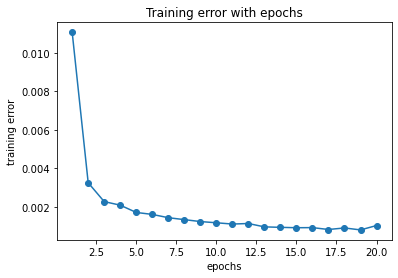

In [7]:
# ------------------------------------------- Visualize Training -------------------------------------------
loss = history.history['loss']
epochs = range(1,len(loss)+1)

plt.title('Training error with epochs')
plt.plot(epochs,loss,'-o',label='training loss')
plt.xlabel('epochs')
plt.ylabel('training error')
plt.show()

In [8]:
# ------------------------------------------- Prepare Test Data -------------------------------------------
# load data
test_cur_inv = np.loadtxt('../data/fobss_data/data/Profile 10A/inverter/Inverter_Current.csv', delimiter=';')
test_cur_inv = test_cur_inv[:,1]
test_volt_master = np.loadtxt('../data/fobss_data/data/Profile 10A/battery/Battery_Voltage.csv', delimiter=';')
test_volt_master = test_volt_master[:,1]
test_volt_slave_0_cell_4 = np.loadtxt('../data/fobss_data/data/Profile 10A/cells/Slave_0_Cell_Voltages.csv', delimiter=';')
test_volt_slave_0_cell_4 = test_volt_slave_0_cell_4[:,4]

# prepare prediction
X1_test, y_test, scaler_y = prepare_data(test_cur_inv, test_volt_slave_0_cell_4, False, d_sample, n_steps, gauss_sigma)
X2_test, y_test, scaler_y = prepare_data(test_volt_slave_0_cell_4, test_volt_slave_0_cell_4, False, d_sample, n_steps, gauss_sigma)
X_test = np.append(X1_test, X2_test, axis=2)

print(X_test.shape, y_test.shape)

(2901, 100, 2) (2901, 1)


91/91 [==============================] - 1s 14ms/step


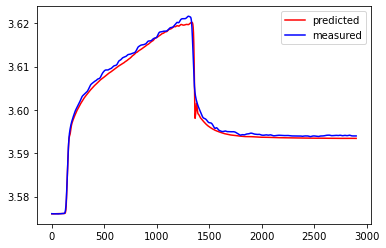

In [9]:
# predict on test data
yhat = model.predict(X_train, verbose = 1)

# unscale data for visualization
yhat_unscaled = scaler_y.inverse_transform(yhat)
y_test_unscaled = scaler_y.inverse_transform(y_test) 

# plot test results
plt.plot(yhat_unscaled, color='red', label = 'predicted')
plt.plot(y_test_unscaled, color='blue', label = 'measured')
plt.legend()
plt.show()